## Imports

In [1]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [2]:
df = pd.read_csv("data/train.csv")

## Data Preview 

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


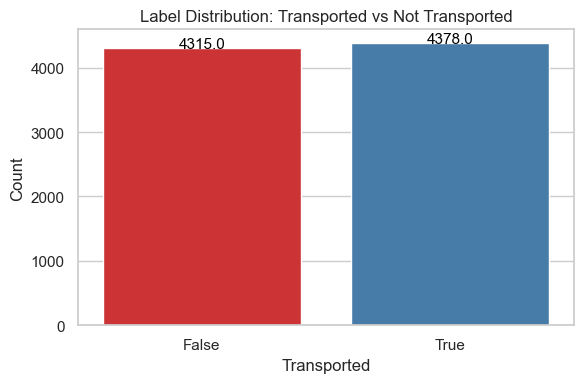

In [4]:
# Set the style
sns.set(style="whitegrid")

# Plot the distribution of the 'Transported' column
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', hue='Transported', data=df, palette='Set1', legend=False)

# Add labels and title
plt.title('Label Distribution: Transported vs Not Transported')
plt.xlabel('Transported')
plt.ylabel('Count')

# Show values on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Gathering Features 

In [6]:
# Drop irrelevant columns
columns_to_drop = ['PassengerId', 'Name']
df.drop(columns_to_drop, axis=1, inplace=True)

# Split the 'Cabin' column into 'Deck', 'CabinNumber', and 'Side'
df['Deck'] = df['Cabin'].str.extract(r'([A-Za-z])')  # Extract the first letter (Deck)
df['CabinNumber'] = df['Cabin'].str.extract(r'(\d+)')  # Extract the digits (Cabin number)
df['Side'] = df['Cabin'].str.extract(r'([PS])')  # Extract the side ('P' for Port, 'S' for Starboard)

# Drop the original 'Cabin' column after the split
df.drop('Cabin', axis=1, inplace=True)

# Combine all the spending features into a single total spend feature
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[spend_cols] = df[spend_cols].fillna(0)  # Fill missing spending data with 0
df['TotalSpend'] = df[spend_cols].sum(axis=1)  # Create TotalSpend as the sum of all spending features


## Fixing Data

In [7]:
# Fill missing values for each of the extracted features
df['Deck'] = df['Deck'].fillna('None')
df['CabinNumber'] = df['CabinNumber'].fillna('None')
df['Side'] = df['Side'].fillna('None')

# Fill missing boolean values (CryoSleep) with false if spenditure was 0
df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)

# Filter the DataFrame to get the rows where VIP is True
vip_df = df[df['VIP'] == True]

# Calculate the average spending of VIPs
avg_vip_spend = vip_df['TotalSpend'].mean()

# Use this average to set the spending threshold
# Fill missing VIP values based on whether TotalSpend exceeds the average VIP spend
df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)

# Fill missing numerical values for 'Age' with the median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing categorical values for 'HomePlanet' and 'Destination' with the most common value (mode)
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])

C:\Users\Santiago\AppData\Local\Temp\ipykernel_1628\3015732875.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_1628\3015732875.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)


# Encoding Data

In [8]:
# Encode HomePlanet
le_homeplanet = LabelEncoder()
df['HomePlanet'] = le_homeplanet.fit_transform(df['HomePlanet'].astype(str))

# Encode Destination
le_destination = LabelEncoder()
df['Destination'] = le_destination.fit_transform(df['Destination'].astype(str))

# Encode Deck
le_deck = LabelEncoder()
df['Deck'] = le_deck.fit_transform(df['Deck'].astype(str))

# Encode CabinNumber
le_cabinnumber = LabelEncoder()
df['CabinNumber'] = le_cabinnumber.fit_transform(df['CabinNumber'].astype(str))

# Encode Side
le_side = LabelEncoder()
df['Side'] = le_side.fit_transform(df['Side'].astype(str))

# Convert CryoSleep and VIP to int
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

## Data Split

In [9]:
df.drop('TotalSpend', axis=1, inplace=True)
# Define features (X) and target (y)
X = df.drop('Transported', axis=1)  # All columns except 'Transported' are features
y = df['Transported']  # 'Transported' is the target variable

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)


## Prediction/Accuracy

In [10]:
my_RandomForest = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=2)
my_RandomForest.fit(X_train, y_train)

y_predict = my_RandomForest.predict(X_test)
y_prob = my_RandomForest.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_predict)

print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")



Accuracy of Random Forest: 0.7895


## Sorting by Importance

In [11]:
importances = my_RandomForest.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))

         Feature  Importance
11   CabinNumber    0.181146
3            Age    0.132031
8            Spa    0.112573
5    RoomService    0.100058
9         VRDeck    0.093031
6      FoodCourt    0.092037
1      CryoSleep    0.080678
7   ShoppingMall    0.073710
10          Deck    0.059355
0     HomePlanet    0.032122
2    Destination    0.020689
12          Side    0.020555
4            VIP    0.002016


## Plotting 

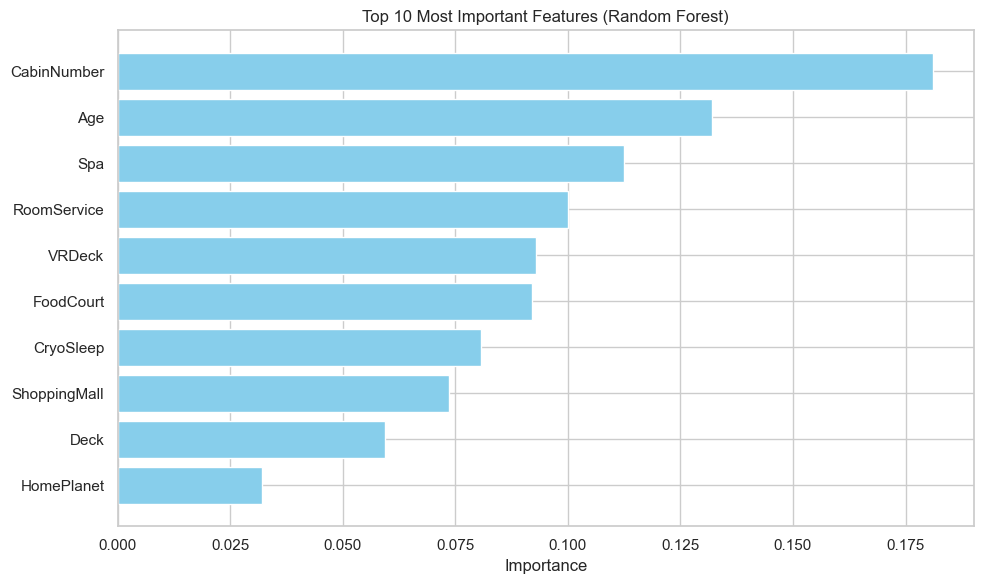

In [17]:

top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(top_n, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Most Important Features (Random Forest)')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


In [13]:
# Print classification report (precision, recall, F1-score)
report = classification_report(y_test, y_predict, output_dict=True)

# Convert to a DataFrame for pretty display
df_report = pd.DataFrame(report).transpose()
df_report.style.background_gradient(cmap='Blues').format(precision=2)

,precision,recall,f1-score,support
False,0.78,0.81,0.79,861.00
True,0.80,0.77,0.79,878.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.79,0.79,0.79,1739.00
weighted avg,0.79,0.79,0.79,1739.00


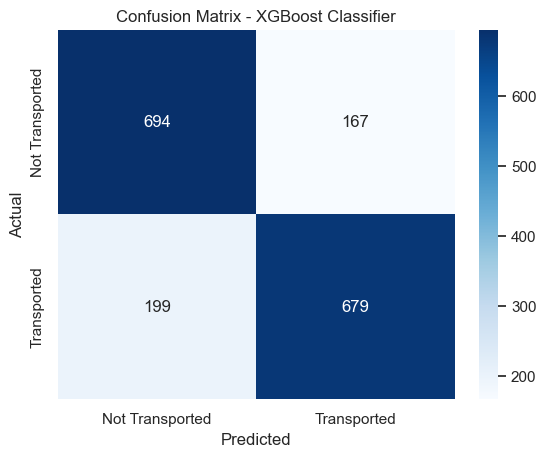

In [14]:
# Print Confusion Matrix
cm = confusion_matrix(y_test, y_predict)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Transported', 'Transported'], yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()